In [41]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS, Adam
from tqdm import tqdm
import copy

def get_data(x_range, y_range, x_num, y_num):
    x = np.linspace(x_range[0], x_range[1], x_num)
    t = np.linspace(y_range[0], y_range[1], y_num)

    x_mesh, t_mesh = np.meshgrid(x,t)
    data = np.concatenate((np.expand_dims(x_mesh, -1), np.expand_dims(t_mesh, -1)), axis=-1)
    
    b_left = data[0,:,:] # x = 0
    b_right = data[-1,:,:] # x = 1
    b_upper = data[:,-1,:] # t = 1
    b_lower = data[:,0,:] # t = 0
    res = data.reshape(-1,2)

    return res, b_left, b_right, b_upper, b_lower


def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn_param=1
        for s in list(p.size()):
            nn_param = nn_param*s
        pp += nn_param
    return pp


def make_time_sequence(src, num_step=5, step=1e-4):
    dim = num_step
    src = np.repeat(np.expand_dims(src, axis=1), dim, axis=1)  # (N, L, 2)
    for i in range(num_step):
        src[:,i,-1] += step*i
    return src


def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])


class WaveAct(nn.Module):
    def __init__(self):
        super(WaveAct, self).__init__() 
        self.w1 = nn.Parameter(torch.ones(1), requires_grad=True)
        self.w2 = nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        return self.w1 * torch.sin(x) + self.w2 * torch.cos(x)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=256):
        super(FeedForward, self).__init__() 
        self.linear = nn.Sequential(*[
            nn.Linear(d_model, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_model)
        ])

    def forward(self, x):
        return self.linear(x)

class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(DecoderLayer, self).__init__()

        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True)
        self.ff = FeedForward(d_model)
        self.act1 = WaveAct()
        self.act2 = WaveAct()

    def forward(self, x, e_outputs): 
        x2 = self.act1(x)
        x = x + self.attn(x2, e_outputs, e_outputs)[0]
        x2 = self.act2(x)
        x = x + self.ff(x2)
        return x

class Decoder(nn.Module):
    def __init__(self, d_model, N, heads):
        super(Decoder, self).__init__()
        self.N = N
        self.layers = get_clones(DecoderLayer(d_model, heads), N)
        self.act = WaveAct()
        
    def forward(self, x, e_outputs):
        for i in range(self.N):
            x = self.layers[i](x, e_outputs)
        return self.act(x)
    
    
class FourierFeatures(nn.Module):
    def __init__(self, in_features, mapping_size=32, scale=0.01):
        super(FourierFeatures, self).__init__()
        self.B = nn.Parameter(torch.randn(in_features, mapping_size) * scale, requires_grad=False)

    def forward(self, x):
        # x: (..., in_features)
        x_proj = 2 * np.pi * x @ self.B  # (..., mapping_size)
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class EnhancedEmbedding(nn.Module):
    def __init__(self, in_features, d_model, mapping_size=32):
        super(EnhancedEmbedding, self).__init__()
        self.fourier = FourierFeatures(in_features, mapping_size)
        # Adjust the linear layer to account for the increased dimensionality (2*mapping_size)
        self.linear = nn.Linear(2 * mapping_size, d_model)
        # Optionally, add a learnable positional embedding
        self.pos_emb = nn.Linear(in_features, d_model)

    def forward(self, x):
        fourier_features = self.fourier(x)
        token_emb = self.linear(fourier_features)
        pos_emb = self.pos_emb(x)
        return token_emb + pos_emb


class DecoderOnlyPINNsformer(nn.Module):
    def __init__(self, d_out, d_model, d_hidden, N, heads, mapping_size=32):
        super(DecoderOnlyPINNsformer, self).__init__()

        # Use the EnhancedEmbedding module which combines Fourier features and a learnable positional embedding.
        self.embedding = EnhancedEmbedding(in_features=2, d_model=d_model, mapping_size=mapping_size)
        self.decoder = Decoder(d_model, N, heads)
        self.linear_out = nn.Sequential(
            nn.Linear(d_model, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_out)
        )

    def forward(self, x, t):
        # Concatenate spatial and temporal information.
        src = torch.cat((x, t), dim=-1)
        # Apply enhanced embedding.
        src = self.embedding(src)
        # The decoder attends to the enhanced embedding.
        d_output = self.decoder(src, src)
        output = self.linear_out(d_output)
        return output





# Set seeds for reproducibility
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

step_size = 1e-4
# Train PINNsformer
res, b_left, b_right, b_upper, b_lower = get_data([0,2*np.pi], [0,1], 51, 51)
res_test, _, _, _, _ = get_data([0,2*np.pi], [0,1], 101, 101)

res = make_time_sequence(res, num_step=5, step=step_size)
b_left = make_time_sequence(b_left, num_step=5, step=step_size)
b_right = make_time_sequence(b_right, num_step=5, step=step_size)
b_upper = make_time_sequence(b_upper, num_step=5, step=step_size)
b_lower = make_time_sequence(b_lower, num_step=5, step=step_size)

res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)

x_res, t_res = res[:,:,0:1], res[:,:,1:2]
x_left, t_left = b_left[:,:,0:1], b_left[:,:,1:2]
x_right, t_right = b_right[:,:,0:1], b_right[:,:,1:2]
x_upper, t_upper = b_upper[:,:,0:1], b_upper[:,:,1:2]
x_lower, t_lower = b_lower[:,:,0:1], b_lower[:,:,1:2]

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

# Note: d_model (here 32) should be even for the Fourier features mapping.
model = DecoderOnlyPINNsformer(d_out=1, d_hidden=512, d_model=32, N=1, heads=2).to(device)

model.apply(init_weights)
optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe')
# optim = Adam(model.parameters(), lr = 1e-4)

print(model)
print(get_n_params(model))

n_params = get_n_params(model)

DecoderOnlyPINNsformer(
  (embedding): EnhancedEmbedding(
    (fourier): FourierFeatures()
    (linear): Linear(in_features=64, out_features=32, bias=True)
    (pos_emb): Linear(in_features=2, out_features=32, bias=True)
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0): DecoderLayer(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (ff): FeedForward(
          (linear): Sequential(
            (0): Linear(in_features=32, out_features=256, bias=True)
            (1): WaveAct()
            (2): Linear(in_features=256, out_features=256, bias=True)
            (3): WaveAct()
            (4): Linear(in_features=256, out_features=32, bias=True)
          )
        )
        (act1): WaveAct()
        (act2): WaveAct()
      )
    )
    (act): WaveAct()
  )
  (linear_out): Sequential(
    (0): Linear(in_features=32, out_features=512, bias=True)
    (1): WaveAct()
    (2): Linear(

In [42]:
kernel_size = 300

D1 = kernel_size
D2 = len(x_left)
D3 = len(x_lower)

def compute_ntk(J1, J2):
    Ker = torch.matmul(J1, torch.transpose(J2, 0, 1))
    return Ker

In [43]:
loss_track = []
w1, w2, w3 = 1, 1, 1

pi = torch.tensor(np.pi, dtype=torch.float32, requires_grad=False).to(device)

progress_bar = tqdm(range(500))

for i in progress_bar:
    if i % 20 == 0:
        J1 = torch.zeros((D1, n_params))
        J2 = torch.zeros((D2, n_params))
        J3 = torch.zeros((D3, n_params))

        batch_ind = np.random.choice(len(x_res), kernel_size, replace=False)
        x_train, t_train = x_res[batch_ind], t_res[batch_ind]

        pred_res = model(x_train, t_train)
        pred_left = model(x_left, t_left)
        pred_upper = model(x_upper, t_upper)
        pred_lower = model(x_lower, t_lower)

        for j in range(len(x_train)):
            model.zero_grad()
            pred_res[j,0].backward(retain_graph=True)
            J1[j, :] = torch.cat([
                p.grad.view(-1) if p.grad is not None else torch.zeros_like(p).view(-1) 
                for p in model.parameters()
                ])


        for j in range(len(x_left)):
            model.zero_grad()
            pred_left[j,0].backward(retain_graph=True)
            J2[j, :] = torch.cat([
                p.grad.view(-1) if p.grad is not None else torch.zeros_like(p).view(-1) 
                for p in model.parameters()
                ])

        for j in range(len(x_lower)):
            model.zero_grad()
            pred_lower[j,0].backward(retain_graph=True)
            pred_upper[j,0].backward(retain_graph=True)
            J3[j, :] = torch.cat([
                p.grad.view(-1) if p.grad is not None else torch.zeros_like(p).view(-1) 
                for p in model.parameters()
                ])

        K1 = torch.trace(compute_ntk(J1, J1))
        K2 = torch.trace(compute_ntk(J2, J2))
        K3 = torch.trace(compute_ntk(J3, J3))
        
        K = K1+K2+K3

        w1 = K.item() / K1.item()
        w2 = K.item() / K2.item()
        w3 = K.item() / K3.item()

    def closure():
        pred_res = model(x_res, t_res)
        pred_left = model(x_left, t_left)
        pred_right = model(x_right, t_right)
        pred_upper = model(x_upper, t_upper)
        pred_lower = model(x_lower, t_lower)

        u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]

        loss_res = torch.mean((u_t - 5 * pred_res * (1-pred_res)) ** 2)
        loss_bc = torch.mean((pred_upper - pred_lower) ** 2)
        loss_ic = torch.mean((pred_left[:,0] - torch.exp(- (x_left[:,0] - torch.pi)**2 / (2*(torch.pi/4)**2))) ** 2)

        loss_track.append([loss_res.item(), loss_bc.item(), loss_ic.item()])

        loss = w1 * loss_res + w2* loss_bc + w2* loss_ic
        optim.zero_grad()
        loss.backward()
        return loss

    optim.step(closure)
            
    last_loss = loss_track[-1]
    progress_bar.set_postfix({
        "res": f"{last_loss[0]:.6f}",
        "ic": f"{last_loss[1]:.6f}",
        "bc": f"{last_loss[2]:.6f}",
    })

100%|██████████| 500/500 [05:59<00:00,  1.39it/s, res=0.000006, ic=0.000000, bc=0.000000]


Loss Res: 0.000006, Loss_BC: 0.000000, Loss_IC: 0.000000
NTK weight: w_res: 1.682352 w_ic: 9.637026, w_bc: 3.313148
Train Loss: 0.000006
relative L1 error: 0.007654
relative L2 error: 0.016825


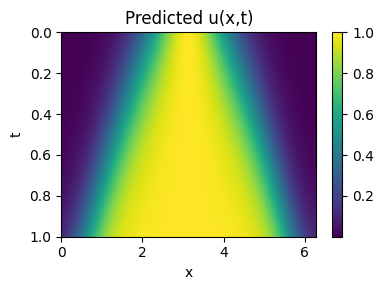

In [47]:
# Visualize PINNsformer

print('Loss Res: {:4f}, Loss_BC: {:4f}, Loss_IC: {:4f}'.format(loss_track[-1][0], loss_track[-1][1], loss_track[-1][2]))
print('NTK weight: w_res: {:4f} w_ic: {:4f}, w_bc: {:4f}'.format(w1, w2, w3))
print('Train Loss: {:4f}'.format(np.sum(loss_track[-1])))

res_test = make_time_sequence(res_test, num_step=5, step=1e-4) 
res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
x_test, t_test = res_test[:,:,0:1], res_test[:,:,1:2]

with torch.no_grad():
    pred = model(x_test, t_test)[:,0:1]
    pred = pred.cpu().detach().numpy()

pred = pred.reshape(101,101)

def h(x):
    return np.exp( - (x-np.pi)**2 / (2 * (np.pi/4)**2))

def u_ana(x,t):
    return h(x) * np.exp(5*t) / ( h(x) * np.exp(5*t) + 1 - h(x))

res_test, _, _, _, _ = get_data([0,2*np.pi], [0,1], 101, 101)
u = u_ana(res_test[:,0], res_test[:,1]).reshape(101,101)

rl1 = np.sum(np.abs(u-pred)) / np.sum(np.abs(u))
rl2 = np.sqrt(np.sum((u-pred)**2) / np.sum(u**2))

print('relative L1 error: {:4f}'.format(rl1))
print('relative L2 error: {:4f}'.format(rl2))

plt.figure(figsize=(4,3))
plt.imshow(pred, extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.show()

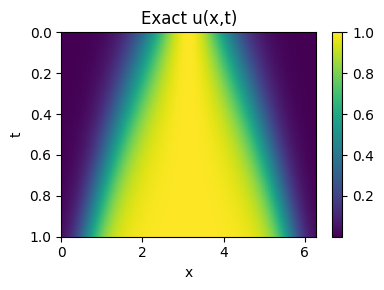

In [48]:
plt.figure(figsize=(4,3))
plt.imshow(u, extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Exact u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.show()

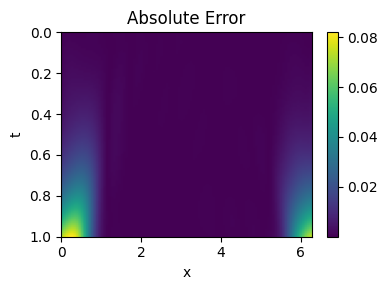

In [49]:
plt.figure(figsize=(4,3))
plt.imshow(np.abs(pred - u), extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Absolute Error')
plt.colorbar()
plt.tight_layout()
plt.show()